In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')




In [2]:
# 1. Data Preprocessing - Merging customer profile and transaction data
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID', how='inner')

# 2. Feature Engineering: Creating relevant features from transaction data
customer_metrics = merged_df.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count')
).reset_index()

# Adding customer profile data (region, signup date)
customer_profile = customers_df[['CustomerID', 'Region']]
customer_data = pd.merge(customer_metrics, customer_profile, on='CustomerID', how='left')

In [3]:

# 3. Convert categorical variable ('Region') to dummy variables (one-hot encoding)
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# 4. Normalize data (standard scaling)
scaler = StandardScaler()
features = ['total_spent', 'transaction_count'] + [col for col in customer_data.columns if 'Region_' in col]
customer_data_scaled = scaler.fit_transform(customer_data[features])

# 5. Clustering using K-Means (with 2 to 10 clusters)
db_indexes = []
inertia_values = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Added n_init=10
    kmeans.fit(customer_data_scaled)
    
    # Davies-Bouldin Index
    db_index = davies_bouldin_score(customer_data_scaled, kmeans.labels_)
    db_indexes.append(db_index)
    
    # Store inertia (optional for evaluation)
    inertia_values.append(kmeans.inertia_)

c:\Users\Priyansh saxena\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Priyansh saxena\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Priyansh saxena\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Priyansh saxena\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1024, in __init__
    self._execute_child(arg

In [4]:
# Find the best k based on Davies-Bouldin Index (lower is better)
best_k = np.argmin(db_indexes) + 2  # Adding 2 because range starts from 2
print(f"Best k based on Davies-Bouldin Index: {best_k}")

# Fit KMeans with the best k
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)  # Added n_init=10
customer_data['Cluster'] = kmeans_final.fit_predict(customer_data_scaled)

# 6. PCA for visualization (reduce to 2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_data_scaled)
customer_data['PCA1'], customer_data['PCA2'] = pca_components[:, 0], pca_components[:, 1]

Best k based on Davies-Bouldin Index: 10


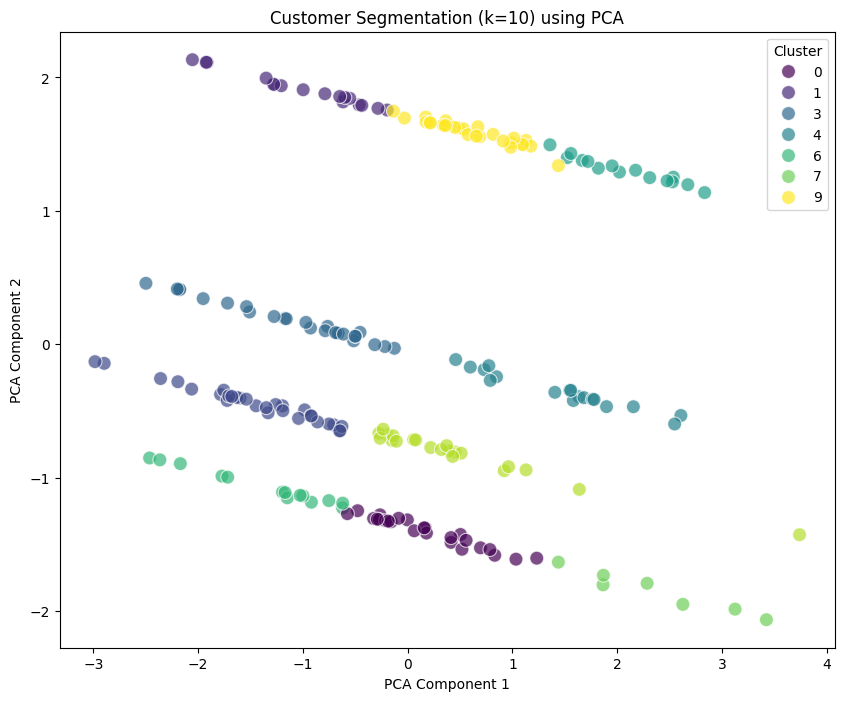

In [5]:
# 7. Plotting the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='viridis', s=100, alpha=0.7)
plt.title(f'Customer Segmentation (k={best_k}) using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()



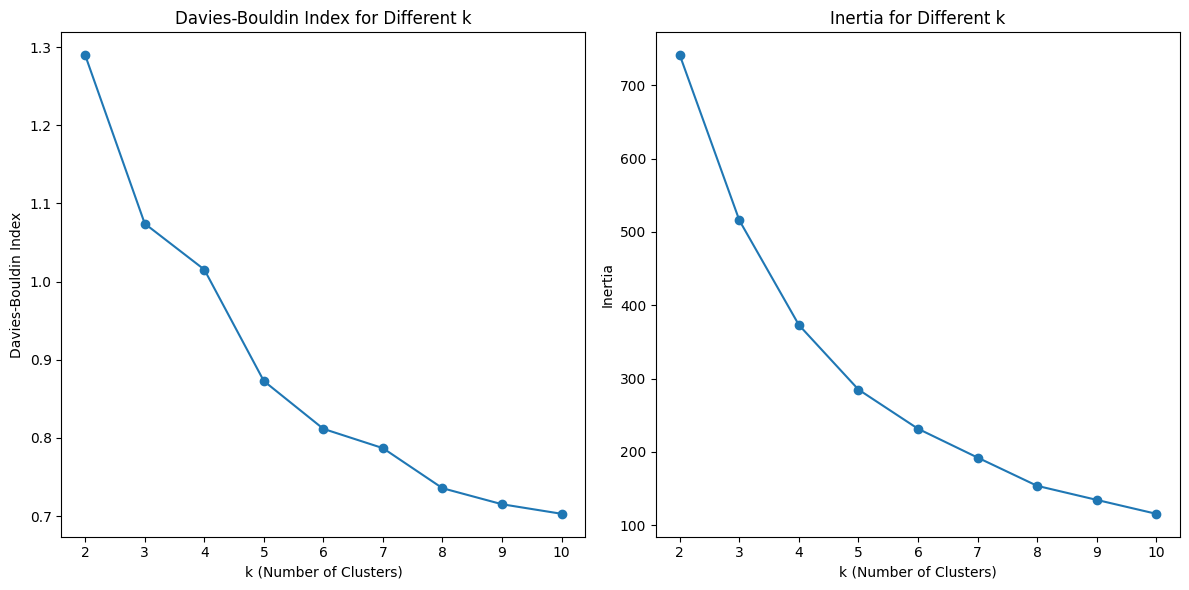

In [6]:
# 8. Optional: Display the Davies-Bouldin Index and Inertia values for each k
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), db_indexes, marker='o')
plt.title('Davies-Bouldin Index for Different k')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Davies-Bouldin Index')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), inertia_values, marker='o')
plt.title('Inertia for Different k')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()